# Zillow: What is driving the errors in the Zestimates?

- The Zillow Data Science Team wants to understand what is driving the errors in the zestimates?
    - Data Scope: 
        - 2017 properties 
        - Single units / Single family homes

In [1]:
# imports for libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

# imports from env file for credentials
from env import user, host, password

# sklearn imports
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# imports from files
import acquire
import prepare

# ignore the warnings
import warnings
warnings.filterwarnings("ignore")

# supress scientific notation
np.set_printoptions(suppress=True)

# only have 2 decimal points for any calculations
pd.options.display.float_format = '{:,.2f}'.format 
#%precision %.2f

# Acquire

In [2]:
# run the sql query from acquire to acquire the zillow data
df = acquire.get_zillow_data()

In [3]:
# look at the first 5 rows of our new dataframe, transposed
df.head().T

,0,1,2,3,4
parcelid,"14,297,519.00","17,052,889.00","14,186,244.00","12,177,905.00","12,095,076.00"
logerror,0.03,0.06,0.01,-0.10,-0.00
bathroomcnt,3.50,1.00,2.00,3.00,3.00
bedroomcnt,4.00,2.00,3.00,4.00,4.00
calculatedfinishedsquarefeet,"3,100.00","1,465.00","1,243.00","2,376.00","2,962.00"
fips,"6,059.00","6,111.00","6,059.00","6,037.00","6,037.00"
latitude,"33,634,931.00","34,449,266.00","33,886,168.00","34,245,180.00","34,145,202.00"
longitude,"-117,869,207.00","-119,281,531.00","-117,823,170.00","-118,240,722.00","-118,179,824.00"
lotsizesquarefeet,"4,506.00","12,647.00","8,432.00","13,038.00","63,000.00"
regionidcity,"53,571.00","13,091.00","21,412.00","396,551.00","47,019.00"


In [4]:
df.shape

(52442, 17)

# Clean and Prep

1. Drop Observations with Missing Values
- df.isna() will return the dataframe structure (rows & columns with names) with 'True' where value is missing and 'False' where not. 

- adding .sum (df.isna().sum()) will then sum each column. Remember that False == 0 and True == 1, so summing across those will ultimately give the number of Trues, or the number of cells missing, per column. 

- adding the last .sum (df.isna().sum().sum()) will then sum the results of each column. 

- NOTE: the result tells us there are AT MOST that many observations with a missing value. If is likely fewer,  depending on the number of observations are missing values from multiple variables. 

In [5]:
df.isna().sum().sum()

1720

In [6]:
# We will drop all observations with one or more missing values: 
df.dropna(inplace=True)

In [7]:
# confirm there are now no missing values after dropingna:
df.isna().sum().sum()

0

Let's see how many rows we actually ended up dropping. From above when we first ran df.shape, we saw we had 52,442 observations

In [8]:
print('We dropped {} rows'.format(52442-df.shape[0]))

We dropped 1529 rows


Get county names and create dummy variables with those.

- Replace fips/county with the county name and create dummy vars for county, or split into 3 different dataframes.

    - 6037: Los Angeles County
    - 6059: Orange County
    - 6111: Ventura County

https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013697

In [9]:
prepare.get_counties()

,parcelid,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,regionidzip,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,LA,Orange,Ventura
0,14297519,0.03,3.50,4.00,"3,100.00","6,059.00","33,634,931.00","-117,869,207.00","4,506.00","53,571.00","96,978.00","1,998.00","485,713.00","1,023,282.00","537,569.00","11,013.72",0,1,0
1,17052889,0.06,1.00,2.00,"1,465.00","6,111.00","34,449,266.00","-119,281,531.00","12,647.00","13,091.00","97,099.00","1,967.00","88,000.00","464,000.00","376,000.00","5,672.48",0,0,1
2,14186244,0.01,2.00,3.00,"1,243.00","6,059.00","33,886,168.00","-117,823,170.00","8,432.00","21,412.00","97,078.00","1,962.00","85,289.00","564,778.00","479,489.00","6,488.30",0,1,0
3,12177905,-0.10,3.00,4.00,"2,376.00","6,037.00","34,245,180.00","-118,240,722.00","13,038.00","396,551.00","96,330.00","1,970.00","108,918.00","145,143.00","36,225.00","1,777.51",1,0,0
4,12095076,-0.00,3.00,4.00,"2,962.00","6,037.00","34,145,202.00","-118,179,824.00","63,000.00","47,019.00","96,293.00","1,950.00","276,684.00","773,303.00","496,619.00","9,516.26",1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52437,11000655,0.02,2.00,2.00,"1,286.00","6,037.00","34,245,368.00","-118,282,383.00","47,405.00","12,447.00","96,284.00","1,940.00","70,917.00","354,621.00","283,704.00","4,478.43",1,0,0
52438,17239384,0.01,2.00,4.00,"1,612.00","6,111.00","34,300,140.00","-118,706,327.00","12,105.00","27,110.00","97,116.00","1,964.00","50,683.00","67,205.00","16,522.00","1,107.48",0,0,1
52439,12773139,0.04,1.00,3.00,"1,032.00","6,037.00","34,040,895.00","-118,038,169.00","5,074.00","36,502.00","96,480.00","1,954.00","32,797.00","49,546.00","16,749.00",876.43,1,0,0
52440,12826780,0.01,2.00,3.00,"1,762.00","6,037.00","33,937,685.00","-117,996,709.00","6,347.00","14,634.00","96,171.00","1,955.00","140,000.00","522,000.00","382,000.00","6,317.15",1,0,0


2. Get county names and create dummy variables with those.

In [10]:
df = prepare.get_counties()
type(df)

pandas.core.frame.DataFrame

In [11]:
df.head().T

,0,1,2,3,4
parcelid,"14,297,519.00","17,052,889.00","14,186,244.00","12,177,905.00","12,095,076.00"
logerror,0.03,0.06,0.01,-0.10,-0.00
bathroomcnt,3.50,1.00,2.00,3.00,3.00
bedroomcnt,4.00,2.00,3.00,4.00,4.00
calculatedfinishedsquarefeet,"3,100.00","1,465.00","1,243.00","2,376.00","2,962.00"
fips,"6,059.00","6,111.00","6,059.00","6,037.00","6,037.00"
latitude,"33,634,931.00","34,449,266.00","33,886,168.00","34,245,180.00","34,145,202.00"
longitude,"-117,869,207.00","-119,281,531.00","-117,823,170.00","-118,240,722.00","-118,179,824.00"
lotsizesquarefeet,"4,506.00","12,647.00","8,432.00","13,038.00","63,000.00"
regionidcity,"53,571.00","13,091.00","21,412.00","396,551.00","47,019.00"


In [12]:
df.shape

(52442, 19)

In [13]:
# Lets confirm we have expected results
print("LA County Verified: ", df[df.fips==6037]['fips'].count() == df.LA.sum())
print("Orange County Verified: ", df[df.fips==6059]['fips'].count() == df.Orange.sum())
print("Ventura County Verified: ", df[df.fips==6111]['fips'].count() == df.Ventura.sum())

LA County Verified:  True
Orange County Verified:  True
Ventura County Verified:  True


3. Compute new features out of existing features in order to reduce noise, capture signals, and reduce collinearity, or dependence between independent variables.

- age: 2017 - year built.

- tax_rate: taxamount/taxvaluedollarcnt fields (total, land & structure). We can then remove taxamount and taxvaluedollarcnt, and will keep taxrate, tructuretaxvaluedollarcnt, and landtaxvalue.

- acres: lotsizesquarefeet/43560

- structure_dollar_per_sqft: structure tax value/finished square feet

- land_dollar_per_sqft: land tax value/lot size square feet

- bed_bath_ratio: bedroomcnt/bathroomcnt

- cola: city of LA, LA has the largest number of records (across single cities) with a very wide range in values, so we I am creating a boolean feature for city of LA. That will help the model for LA county.

In [14]:
df = prepare.create_features(df)
df.head().T

,0,1,2,3,4
parcelid,"14,297,519.00","17,052,889.00","14,186,244.00","12,177,905.00","12,095,076.00"
logerror,0.03,0.06,0.01,-0.10,-0.00
bathroomcnt,3.50,1.00,2.00,3.00,3.00
bedroomcnt,4.00,2.00,3.00,4.00,4.00
calculatedfinishedsquarefeet,"3,100.00","1,465.00","1,243.00","2,376.00","2,962.00"
fips,"6,059.00","6,111.00","6,059.00","6,037.00","6,037.00"
latitude,"33,634,931.00","34,449,266.00","33,886,168.00","34,245,180.00","34,145,202.00"
longitude,"-117,869,207.00","-119,281,531.00","-117,823,170.00","-118,240,722.00","-118,179,824.00"
lotsizesquarefeet,"4,506.00","12,647.00","8,432.00","13,038.00","63,000.00"
regionidcity,"53,571.00","13,091.00","21,412.00","396,551.00","47,019.00"


4. Remove Outliers

- What do the distributions look like currently?

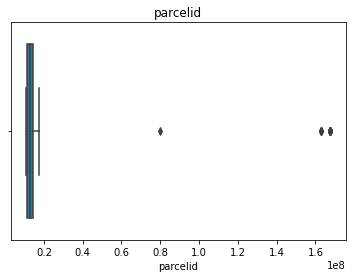

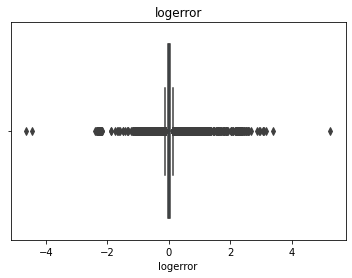

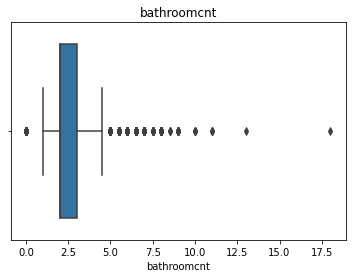

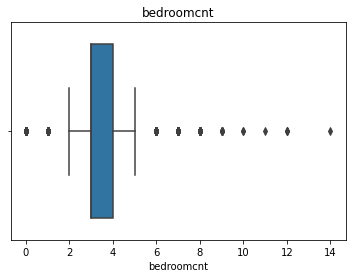

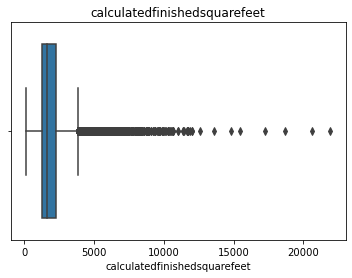

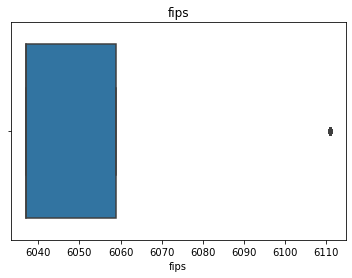

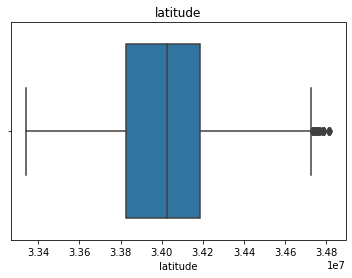

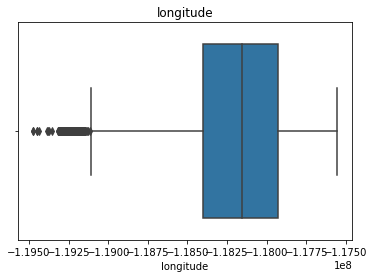

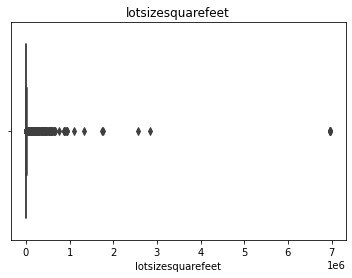

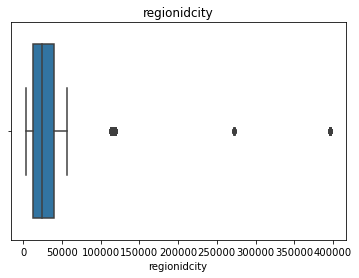

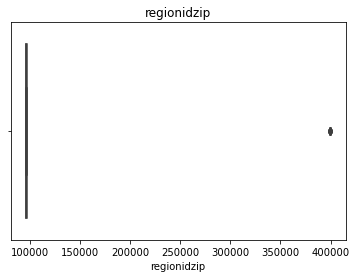

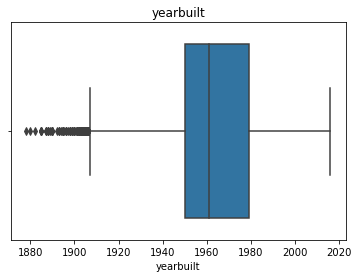

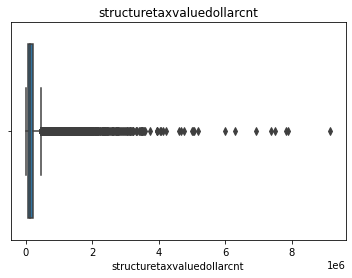

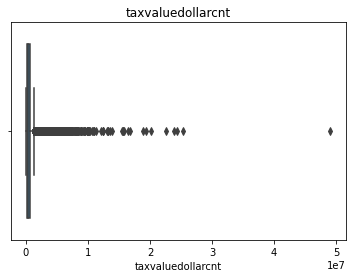

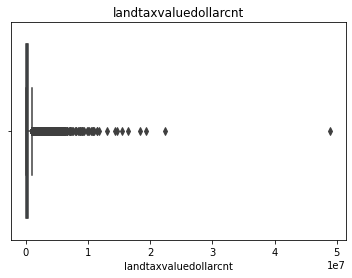

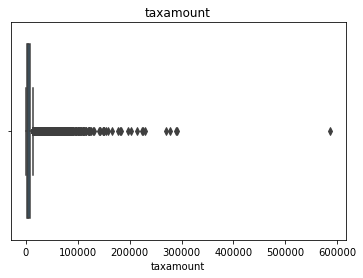

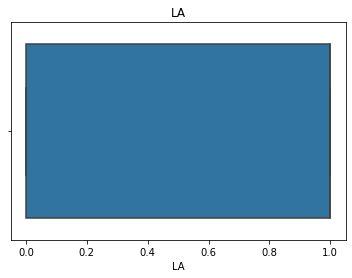

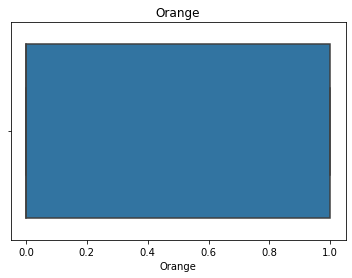

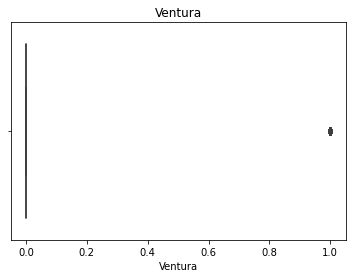

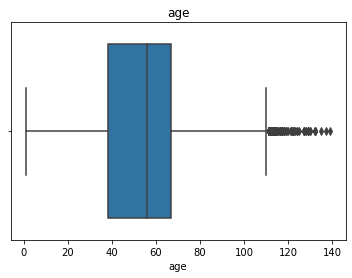

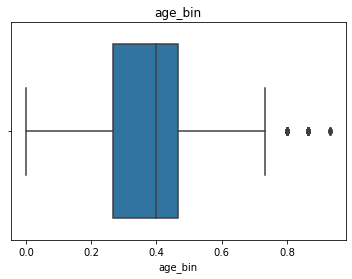

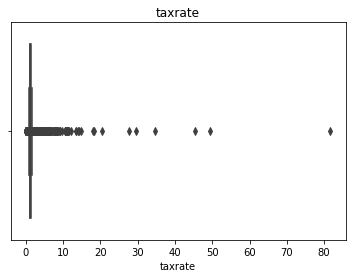

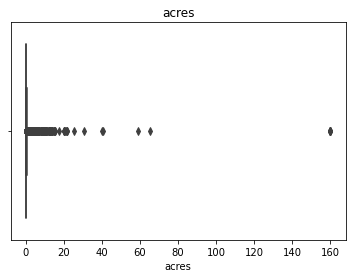

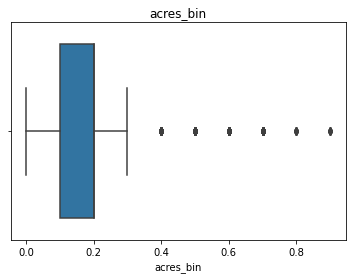

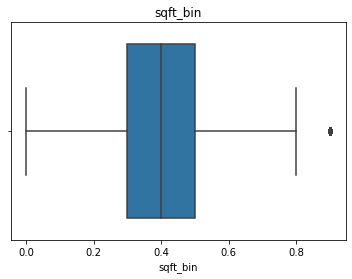

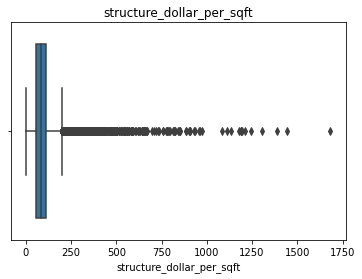

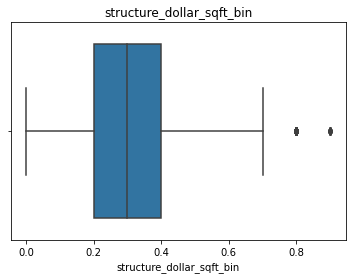

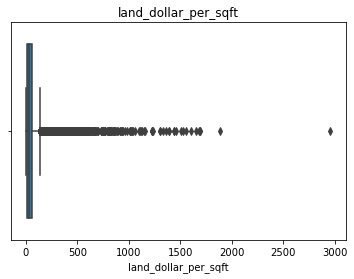

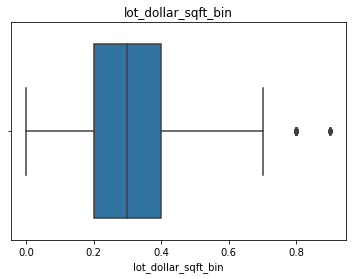

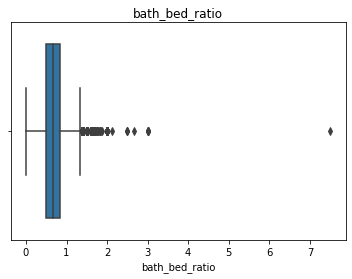

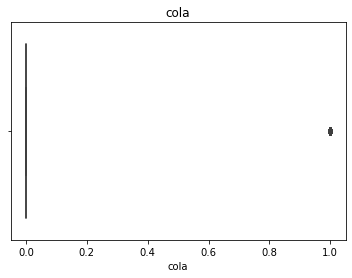

In [15]:
for col in df.columns:
    sns.boxplot(df[col])
    plt.title(col)
    plt.show()

1. Remove extremes in bedrooms and baths, we will keeps homes with between 1 and 7 baths, between 0 and 7 bedrooms

2. There is an error in zip, so we will remove those whose zips are invalid numbers (> 99999).

3. remove square feet > 10000 for now

4. remove lot size (acres) > 20 for now

5. What is this tax rate of almost 50%?? Remove tax rate > 10% for now.

In [16]:
df.head()

,parcelid,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,...,taxrate,acres,acres_bin,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,cola
0,14297519,0.03,3.50,4.00,"3,100.00","6,059.00","33,634,931.00","-117,869,207.00","4,506.00","53,571.00",...,1.08,0.10,0.10,0.70,156.68,0.50,119.30,0.50,0.88,0
1,17052889,0.06,1.00,2.00,"1,465.00","6,111.00","34,449,266.00","-119,281,531.00","12,647.00","13,091.00",...,1.22,0.29,0.30,0.30,60.07,0.20,29.73,0.30,0.50,0
2,14186244,0.01,2.00,3.00,"1,243.00","6,059.00","33,886,168.00","-117,823,170.00","8,432.00","21,412.00",...,1.15,0.19,0.20,0.20,68.62,0.20,56.87,0.40,0.67,0
3,12177905,-0.10,3.00,4.00,"2,376.00","6,037.00","34,245,180.00","-118,240,722.00","13,038.00","396,551.00",...,1.22,0.30,0.30,0.50,45.84,0.10,2.78,0.10,0.75,0
4,12095076,-0.00,3.00,4.00,"2,962.00","6,037.00","34,145,202.00","-118,179,824.00","63,000.00","47,019.00",...,1.23,1.45,0.50,0.60,93.41,0.30,7.88,0.20,0.75,0


In [17]:
import prepare

In [18]:
df = prepare.remove_outliers()
df.head()

,parcelid,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,regionidcounty,regionidzip,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount
0,14297519,0.03,3.50,4.00,"3,100.00","6,059.00","33,634,931.00","-117,869,207.00","4,506.00","53,571.00","1,286.00","96,978.00","1,998.00","485,713.00","1,023,282.00","537,569.00","11,013.72"
1,17052889,0.06,1.00,2.00,"1,465.00","6,111.00","34,449,266.00","-119,281,531.00","12,647.00","13,091.00","2,061.00","97,099.00","1,967.00","88,000.00","464,000.00","376,000.00","5,672.48"
2,14186244,0.01,2.00,3.00,"1,243.00","6,059.00","33,886,168.00","-117,823,170.00","8,432.00","21,412.00","1,286.00","97,078.00","1,962.00","85,289.00","564,778.00","479,489.00","6,488.30"
3,12177905,-0.10,3.00,4.00,"2,376.00","6,037.00","34,245,180.00","-118,240,722.00","13,038.00","396,551.00","3,101.00","96,330.00","1,970.00","108,918.00","145,143.00","36,225.00","1,777.51"
4,12095076,-0.00,3.00,4.00,"2,962.00","6,037.00","34,145,202.00","-118,179,824.00","63,000.00","47,019.00","3,101.00","96,293.00","1,950.00","276,684.00","773,303.00","496,619.00","9,516.26"


In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
parcelid,"52,120.00","12,955,044.31","2,274,805.97","10,711,855.00","11,506,688.75","12,577,655.00","14,127,267.50","162,960,814.00"
logerror,"52,120.00",0.02,0.17,-4.66,-0.02,0.01,0.04,3.39
bathroomcnt,"52,120.00",2.29,0.98,1.00,2.00,2.00,3.00,7.00
bedroomcnt,"52,120.00",3.30,0.92,1.00,3.00,3.00,4.00,7.00
calculatedfinishedsquarefeet,"52,120.00","1,906.98",937.70,152.00,"1,267.00","1,656.00","2,299.25","9,848.00"
fips,"52,120.00","6,049.11",21.00,"6,037.00","6,037.00","6,037.00","6,059.00","6,111.00"
latitude,"52,120.00","34,022,494.70","274,066.77","33,340,620.00","33,826,805.50","34,022,811.00","34,187,348.50","34,818,767.00"
longitude,"52,120.00","-118,193,519.34","356,168.65","-119,475,265.00","-118,399,722.50","-118,152,611.50","-117,929,080.50","-117,554,636.00"
lotsizesquarefeet,"51,783.00","11,140.69","86,636.94",236.00,"5,576.50","6,828.00","8,750.50","6,971,010.00"
regionidcity,"51,115.00","33,545.81","49,271.71","3,491.00","12,447.00","24,812.00","40,227.00","396,556.00"


In [20]:
df.shape

(52120, 17)

In [21]:
type(df)

pandas.core.frame.DataFrame

In [22]:
target_var = 'logerror'
target_var

'logerror'

In [23]:
type(target_var)

str

In [24]:
prepare.split(df, target_var)

[       parcelid  logerror  bathroomcnt  bedroomcnt  \
 4805   12535098      0.00         2.00        3.00   
 9123   10713904     -0.00         2.00        3.00   
 38401  12385211     -0.01         2.00        3.00   
 26923  12597233     -0.03         2.00        3.00   
 4424   13989121      0.01         2.00        3.00   
 ...         ...       ...          ...         ...   
 19331  12268972     -0.03         1.00        2.00   
 42686  11226968     -0.00         2.00        4.00   
 6715   14239434      0.10         1.00        2.00   
 3294   14503028     -0.01         2.00        3.00   
 45143  12951350      0.20         3.00        2.00   
 
        calculatedfinishedsquarefeet     fips      latitude       longitude  \
 4805                       1,947.00 6,037.00 33,774,139.00 -118,144,313.00   
 9123                       1,310.00 6,037.00 34,238,543.00 -118,636,124.00   
 38401                      1,236.00 6,037.00 33,956,738.00 -118,124,560.00   
 26923                

In [25]:
partitions = prepare.split(df, target_var='logerror')

In [26]:
# These bins were too specified and did not show an ultimate cluster, we will narrow down our clusters below:
# train = partitions[0]
# train['logerror_bins'] = pd.cut(train.logerror, [-5, -.2, -.05, .05, .2, 4])
# partitions[0] = train

In [27]:
# Luxury & Opulence vs The Shrinking Middle Class
train = partitions[0]
train['logerror_bins'] = pd.cut(train.logerror, [-5, .2, 4])
partitions[0] = train

In [28]:
train.logerror_bins.value_counts()

(-5.0, 0.2]    27833
(0.2, 4.0]      1354
Name: logerror_bins, dtype: int64

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52120 entries, 0 to 52441
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52120 non-null  int64  
 1   logerror                      52120 non-null  float64
 2   bathroomcnt                   52120 non-null  float64
 3   bedroomcnt                    52120 non-null  float64
 4   calculatedfinishedsquarefeet  52120 non-null  float64
 5   fips                          52120 non-null  float64
 6   latitude                      52120 non-null  float64
 7   longitude                     52120 non-null  float64
 8   lotsizesquarefeet             51783 non-null  float64
 9   regionidcity                  51115 non-null  float64
 10  regionidcounty                52120 non-null  float64
 11  regionidzip                   52120 non-null  float64
 12  yearbuilt                     52092 non-null  float64
 13  s

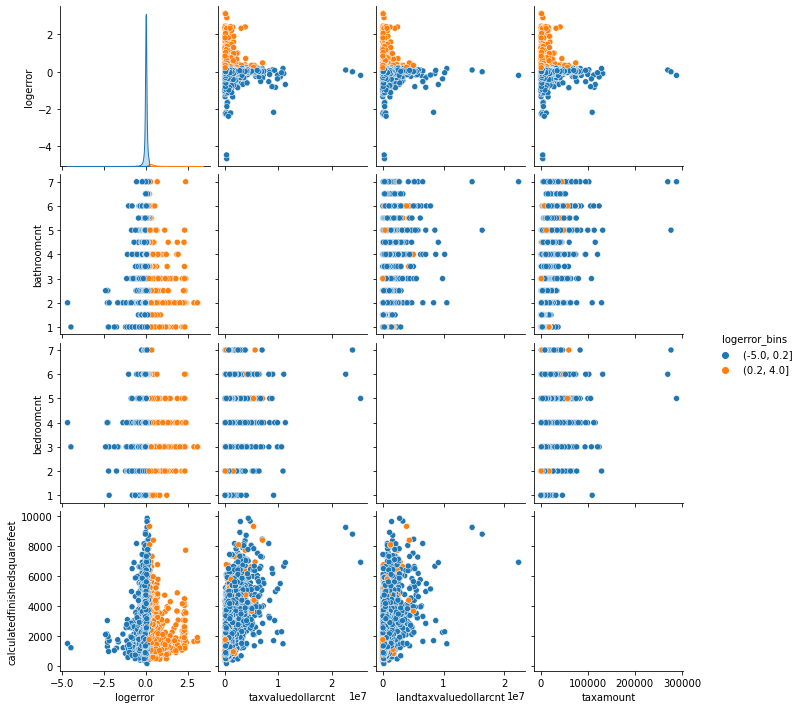

In [30]:
# we are wanting to focus on 'bathroomcnt', 'bedroomcnt' and 'calculatedfinishedsquarefeet' within our Lux and Middle class market clusters
sns.pairplot(data = train, hue = 'logerror_bins', 
             # 'structure_dollar_sqft_bin', 'lot_dollar_sqft_bin',  'taxrate', 'bath_bed_ratio'
             # 'acres', ,  'age'
             x_vars = ['logerror', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount'],
             y_vars = ['logerror', 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet'])

In [31]:
# the variables that still need scaling
scaled_vars = ['latitude', 'longitude', 'bathroomcnt', 'calculatedfinishedsquarefeet']

In [32]:
# create new column names for the scaled variables by adding 'scaled_' to the beginning of each variable name 
scaled_column_names = ['scaled_' + i for i in scaled_vars]

In [33]:
# select the X partitions: [X_train, X_validate, X_test]
X = partitions[1:4]

In [34]:
# fit the minmaxscaler to X_train
X_train = X[0]

In [35]:
scaler = MinMaxScaler(copy=True).fit(X_train[scaled_vars])

In [36]:
# recall: X[0] is X_train, X[1] is X_validate and X[2] is X_test
X[0].describe()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,regionidcounty,regionidzip,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount
count,"29,187.00","29,187.00","29,187.00","29,187.00","29,187.00","29,187.00","29,187.00","28,995.00","28,613.00","29,187.00","29,187.00","29,175.00","29,141.00","29,186.00","29,186.00","29,184.00"
mean,"12,953,654.57",2.29,3.30,"1,904.10","6,049.10","34,022,652.39","-118,192,407.22","10,779.91","33,838.12","2,524.47","96,567.08","1,963.39","189,561.19","512,534.14","323,265.22","6,256.40"
std,"2,132,322.98",0.97,0.92,927.30,20.97,"273,882.03","355,020.58","76,341.68","49,990.22",804.36,421.39,23.01,"216,217.43","638,500.46","479,824.76","7,372.46"
min,"10,711,855.00",1.00,1.00,152.00,"6,037.00","33,340,620.00","-119,448,392.00",236.00,"3,491.00","1,286.00","95,982.00","1,878.00",148.00,"3,254.00",161.00,51.26
25%,"11,516,877.00",2.00,3.00,"1,269.00","6,037.00","33,826,536.50","-118,399,114.00","5,572.00","12,447.00","1,286.00","96,206.00","1,950.00","77,271.00","194,664.50","76,503.00","2,668.34"
50%,"12,585,477.00",2.00,3.00,"1,660.00","6,037.00","34,022,417.00","-118,150,102.00","6,832.00","24,812.00","3,101.00","96,414.00","1,961.00","131,568.00","373,751.50","217,561.00","4,643.81"
75%,"14,126,660.50",3.00,4.00,"2,301.00","6,059.00","34,187,100.00","-117,928,278.00","8,711.00","40,227.00","3,101.00","96,995.00","1,979.00","223,355.00","611,000.00","405,869.00","7,309.91"
max,"162,960,814.00",7.00,7.00,"9,848.00","6,111.00","34,818,767.00","-117,554,636.00","6,971,010.00","396,556.00","3,101.00","97,344.00","2,016.00","7,893,568.00","25,381,250.00","22,335,500.00","288,524.60"


In [37]:
# list of variables I will cluster on. 
#cluster_vars = ['scaled_latitude', 'scaled_longitude', 'age_bin'] 
cluster_vars = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet'] 
cluster_name = 'area_cluster'
k_range = range(2,20)
#k_range = 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19

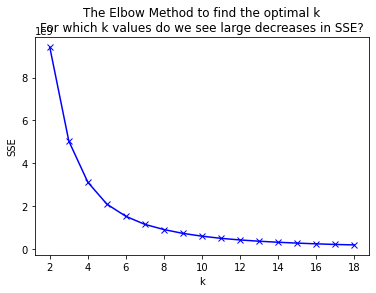

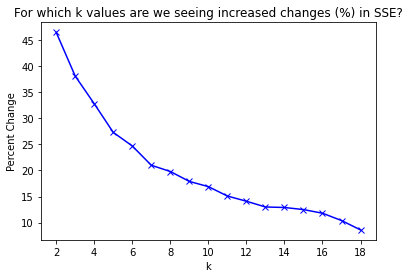

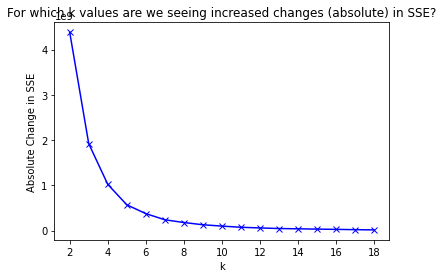

,k,sse,delta,pct_delta
0,2,"9,420,055,556.63","4,381,048,202.00",46.50
1,3,"5,039,007,354.77","1,921,075,702.00",38.10
2,4,"3,117,931,652.38","1,022,708,137.00",32.80
3,5,"2,095,223,515.55","571,063,297.00",27.30
4,6,"1,524,160,218.83","375,796,454.00",24.70
5,7,"1,148,363,764.56","240,679,779.00",21.00
6,8,"907,683,985.83","179,618,407.00",19.80
7,9,"728,065,579.11","130,258,195.00",17.90
8,10,"597,807,384.36","100,746,703.00",16.90
9,11,"497,060,681.36","75,008,208.00",15.10


In [38]:
prepare.find_k(X_train, cluster_vars, k_range)

In [39]:
#need to also look at handling the null values here 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52120 entries, 0 to 52441
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52120 non-null  int64  
 1   logerror                      52120 non-null  float64
 2   bathroomcnt                   52120 non-null  float64
 3   bedroomcnt                    52120 non-null  float64
 4   calculatedfinishedsquarefeet  52120 non-null  float64
 5   fips                          52120 non-null  float64
 6   latitude                      52120 non-null  float64
 7   longitude                     52120 non-null  float64
 8   lotsizesquarefeet             51783 non-null  float64
 9   regionidcity                  51115 non-null  float64
 10  regionidcounty                52120 non-null  float64
 11  regionidzip                   52120 non-null  float64
 12  yearbuilt                     52092 non-null  float64
 13  s

We will try k=6, as we really need more clusters to make this meaningful.

So let's create our clusters.

In [65]:
k = 6
# as reminders: 
cluster_vars = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']
cluster_name = 'area_cluster'

Step 2: Create kmeans object & fit using training data.

In [66]:
prepare.create_clusters(X_train, k, cluster_vars)

KMeans(n_clusters=6, random_state=13)

In [67]:
X = df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]

In [75]:
df, X_scaled, scaler, kmeans, centroids = prepare.create_cluster(df, X, 3)

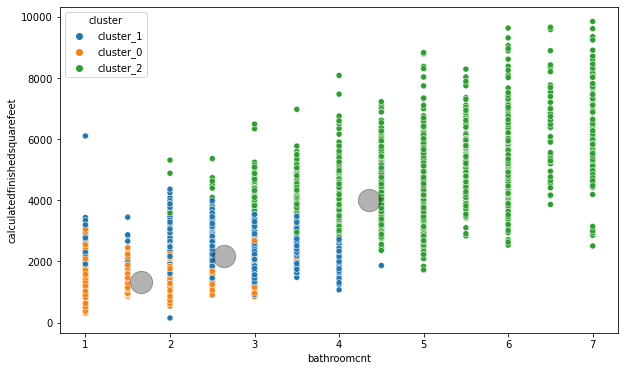

In [76]:
# useful
prepare.create_scatter_plot('bathroomcnt', 'calculatedfinishedsquarefeet',df,kmeans, X_scaled, scaler)

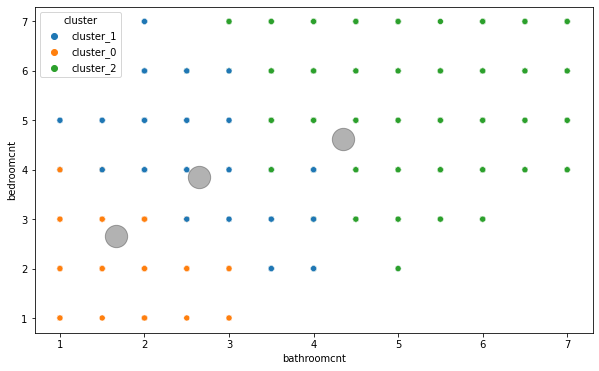

In [70]:
# somewhat useful
prepare.create_scatter_plot('bathroomcnt', 'bedroomcnt',df,kmeans, X_scaled, scaler)

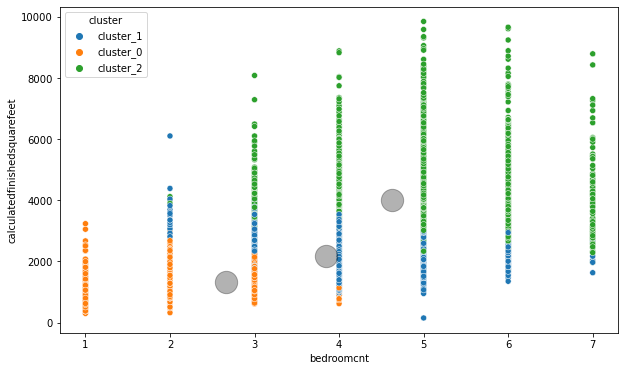

In [71]:
# not super useful
prepare.create_scatter_plot('bedroomcnt', 'calculatedfinishedsquarefeet',df,kmeans, X_scaled, scaler)

Text(0.5, 1.0, 'Actual Logerror with bathroomcnt and calculatedsquarefeet')

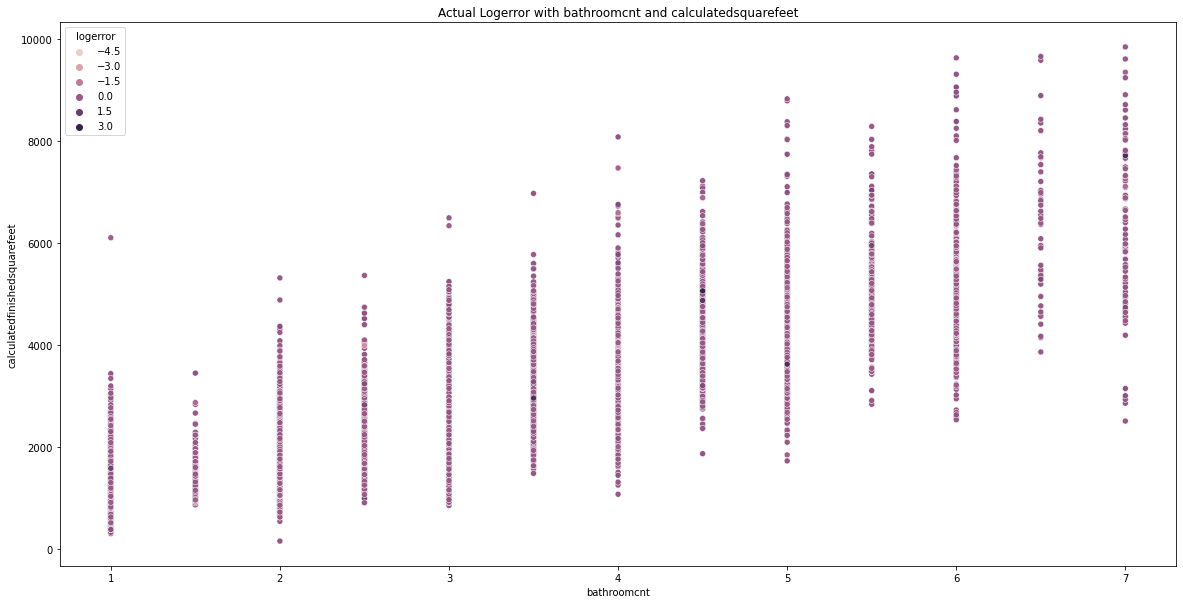

In [82]:
# actual logerror

plt.figure(figsize = (20,10))
sns.scatterplot(x = 'bathroomcnt', y = 'calculatedfinishedsquarefeet', data = df, hue = 'logerror')
plt.title('Actual Logerror with bathroomcnt and calculatedsquarefeet')

<Figure size 1008x648 with 0 Axes>

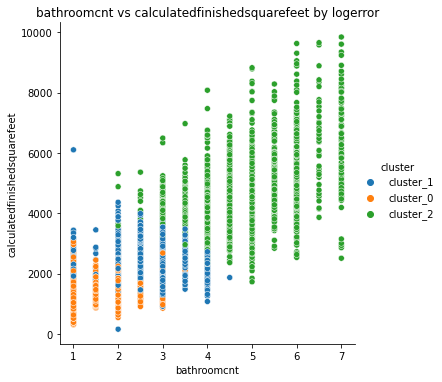

In [85]:
# scatter plot of data with hue for cluster

plt.figure(figsize=(14, 9))
sns.relplot(x = 'bathroomcnt', y = 'calculatedfinishedsquarefeet', data = df, hue = 'cluster')
plt.title('bathroomcnt vs calculatedfinishedsquarefeet by logerror');

<Figure size 1008x648 with 0 Axes>

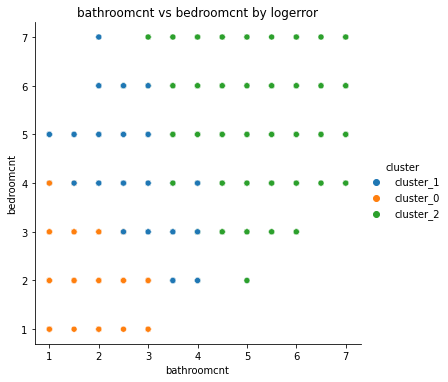

In [86]:
# scatter plot of data with hue for cluster

plt.figure(figsize=(14, 9))
sns.relplot(x = 'bathroomcnt', y = 'bedroomcnt', data = df, hue = 'cluster')
plt.title('bathroomcnt vs bedroomcnt by logerror');